In [12]:
import pickle
import h5py 
import numpy as np
import networkx as nx
from tqdm import tqdm

In [20]:
with h5py.File('../../data/10X_PBMC_select_2100.h5') as f:
    X = np.array(f['X'])
    y = np.array(f['Y'])

In [21]:
y

array([7., 1., 2., ..., 3., 1., 4.])

In [8]:
with open('../../matrices_grafos/10X_PBMC_select_2100/correlaciones.pickle', 'rb') as f:
    correlaciones_10x = pickle.load(f)

In [9]:
correlaciones_10x

array([[ 1.00000000e+00,  1.55653460e-01, -2.11066922e-02, ...,
        -1.93347874e-02,  3.15500796e-03, -8.64667560e-05],
       [ 1.55653460e-01,  1.00000000e+00, -2.40662181e-02, ...,
        -3.09257303e-02,  3.81456421e-02,  6.24394789e-02],
       [-2.11066922e-02, -2.40662181e-02,  1.00000000e+00, ...,
        -2.56389953e-02, -5.12914464e-02, -1.99033539e-02],
       ...,
       [-1.93347874e-02, -3.09257303e-02, -2.56389953e-02, ...,
         1.00000000e+00, -1.44743931e-02, -2.99826181e-02],
       [ 3.15500796e-03,  3.81456421e-02, -5.12914464e-02, ...,
        -1.44743931e-02,  1.00000000e+00, -2.29037571e-02],
       [-8.64667560e-05,  6.24394789e-02, -1.99033539e-02, ...,
        -2.99826181e-02, -2.29037571e-02,  1.00000000e+00]])

In [10]:
def create_kMST(distance_matrix, inverse = True, k = None, threshold = 1e-5):
    if k is None:
        N = np.log(len(distance_matrix))
        k = int(np.floor(N))
    
    print(f'k = {k}')
    grafo = nx.Graph()
    nodos = range(len(distance_matrix))

    # Crear nodo inicial
    grafo.add_nodes_from(nodos)

    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix[i])):
            peso = distance_matrix[i][j]
            if peso > threshold:
                # para MST necesito el inverso de las correlaciones
                if inverse:
                    grafo.add_edge(i, j, weight=1-peso)
                else:
                    grafo.add_edge(i, j, weight=peso)


    print(f'---> Number of edges: {grafo.number_of_edges()}')

    mst_antes = None
    # Creamos los MSTs
    for iter in tqdm(range(k)):
        mst_new = nx.minimum_spanning_tree(grafo)

        edges_to_remove = list(mst_new.edges)
        grafo.remove_edges_from(edges_to_remove)

        if mst_antes is None:
            mst_antes = mst_new.copy()
        else:
            mst_new.add_edges_from(list(mst_antes.edges()))
            mst_antes = mst_new.copy()

    return mst_antes 

In [13]:
mst = create_kMST(correlaciones_10x, threshold=0.1)

k = 7
---> Number of edges: 136717


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


In [14]:
mst

In [15]:
def louvain(grafo):
    particiones = nx.community.louvain_communities(grafo, seed=123)

    diccionario = {}

    # Crear el diccionario
    for i, conjunto in enumerate(particiones):
        for elemento in conjunto:
            diccionario[elemento] = i

    # Crear la lista deseada
    max_elemento = max(max(particiones, key=max), default=-1)
    clusters = np.array([diccionario.get(i, -1) for i in range(max_elemento + 1)])

    return clusters

In [16]:
clusters = louvain(mst)

In [19]:
import networkx as nx
import numpy as np
import argparse
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score, silhouette_score)
from scipy.optimize import linear_sum_assignment
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns
import h5py
import os

In [18]:
def unsupervised_metrics(X, y_pred):
    # Realizamos PCA a 32 componentes
    X = PCA(n_components=32).fit_transform(X)

    # Evaluación final de resultados: métricas comparando con los clusters reales
    try:
        sil = np.round(silhouette_score(X, y_pred), 5)
        chs = np.round(calinski_harabasz_score(X, y_pred), 5)
        dbs = np.round(davies_bouldin_score(X, y_pred), 5)
    except:
        sil, chs, dbs = None, None, None

    return {'sil': sil, 'chs': chs, 'dbs': dbs}

def supervised_metrics(y_true, y_pred):
    acc = round(cluster_acc(y_true, y_pred),3)
    nmi = round(metrics.normalized_mutual_info_score(y_true, y_pred),3)
    ari = round(metrics.adjusted_rand_score(y_true, y_pred),3)

    return {'acc': acc, 'nmi': nmi, 'ari': ari}

def cluster_acc_plot(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    
    df_cm = pd.DataFrame(w, index = [i for i in range(D)], columns = [i for i in range(D)])
    plt.figure(figsize = (10,7))
    w_order = np.zeros((D, D), dtype=np.int64)
    for i in range(D):
        for j in range(D):
            w_order[i,j] = w[i, ind[1][j]]

    df_cm = pd.DataFrame(w_order, index = [i for i in range(D)], columns = [i for i in ind[1]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel("Prediction")
    plt.xlabel("Ground Truth")
    plt.show()
    
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)

    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
        
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)

    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
       

In [22]:
supervised_metrics(y,clusters)

{'acc': 0.76, 'nmi': 0.676, 'ari': 0.63}

In [ ]:
supervised_metrics(y,clusters)

# CORRELACIONES EN MV

In [23]:
with open('correlaciones.pickle', 'rb') as f:
    m = pickle.load(f)

In [26]:
import seaborn as sns

<Axes: >

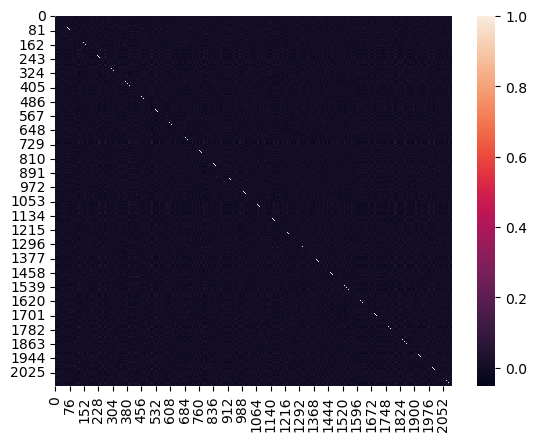

In [27]:
sns.heatmap(m)

<Axes: >

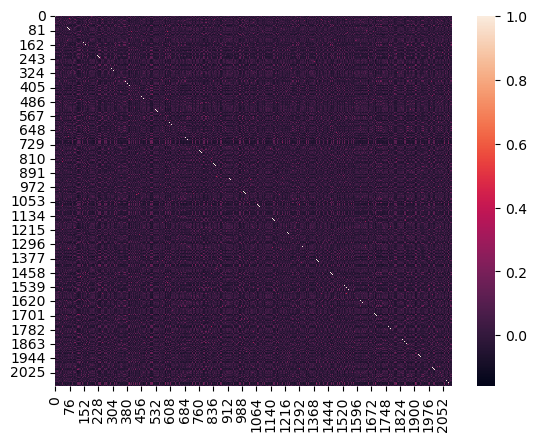

In [28]:
sns.heatmap(correlaciones_10x)

In [29]:
m

array([[ 1.00000000e+00,  1.55413699e-02, -2.32460297e-02, ...,
        -5.16270451e-03,  4.94384357e-03, -3.40458309e-03],
       [ 1.55413699e-02,  1.00000000e+00, -2.19015862e-02, ...,
        -2.02871997e-03,  9.89503548e-03,  8.94486716e-03],
       [-2.32460297e-02, -2.19015862e-02,  1.00000000e+00, ...,
        -1.23829062e-03, -2.07537079e-03, -1.87282797e-02],
       ...,
       [-5.16270451e-03, -2.02871997e-03, -1.23829062e-03, ...,
         1.00000000e+00, -8.56505619e-03, -8.01183499e-03],
       [ 4.94384357e-03,  9.89503548e-03, -2.07537079e-03, ...,
        -8.56505619e-03,  1.00000000e+00,  6.55142221e-04],
       [-3.40458309e-03,  8.94486716e-03, -1.87282797e-02, ...,
        -8.01183499e-03,  6.55142221e-04,  1.00000000e+00]])

In [30]:
correlaciones_10x

array([[ 1.00000000e+00,  1.55653460e-01, -2.11066922e-02, ...,
        -1.93347874e-02,  3.15500796e-03, -8.64667560e-05],
       [ 1.55653460e-01,  1.00000000e+00, -2.40662181e-02, ...,
        -3.09257303e-02,  3.81456421e-02,  6.24394789e-02],
       [-2.11066922e-02, -2.40662181e-02,  1.00000000e+00, ...,
        -2.56389953e-02, -5.12914464e-02, -1.99033539e-02],
       ...,
       [-1.93347874e-02, -3.09257303e-02, -2.56389953e-02, ...,
         1.00000000e+00, -1.44743931e-02, -2.99826181e-02],
       [ 3.15500796e-03,  3.81456421e-02, -5.12914464e-02, ...,
        -1.44743931e-02,  1.00000000e+00, -2.29037571e-02],
       [-8.64667560e-05,  6.24394789e-02, -1.99033539e-02, ...,
        -2.99826181e-02, -2.29037571e-02,  1.00000000e+00]])